In [1]:
import random
import numpy as np
import cPickle
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Data loader and wrapper by "mnielsen" https://github.com/mnielsen/neural-networks-and-deep-learning

def load_data():
    '''Loading the mnist dataset from an archive'''
    f = gzip.open('./mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f)
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    '''Reshaping the data in a tuple with on one hand the greyscale image and on the other the the label (between 0-9)'''
    tr_d, va_d, te_d = load_data()
    
    #Organizing the training set
    #Normalizing and centering the data between [-1,1]
    training_inputs = [np.reshape(x, (784, 1))*2-1 for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    
    #Organizing the validation set
    #Normalizing and centering the data between [-1,1]
    validation_inputs = [np.reshape(x, (784, 1))*2-1 for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    
    #Organizing the testing set
    #Normalizing and centering the data between [-1,1]
    test_inputs = [np.reshape(x, (784, 1))*2-1 for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    '''Vectorizing the output with 1 at the true label and zeroes everywhere else'''
    #Not actulally needed because label are useless in our case but reused from the multi layer perceptron
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

####Activation functions
def activation(z,alpha=0.1):
    '''ReLU'''
    a= np.copy(z)
    a[z<=0] = 0.1*a[z<=0]
    return a

def activation_prime(z):
    '''Derivative of ReLU'''
    a= np.ones_like(z)
    a[z<0] = 0.1
    return a

def tanh(x):
    '''Hyperbolic tangent'''
    return np.tanh(x)

def tanh_prime(x):
    '''Derivative of hyperbolic tangent'''
    return np.ones_like(x)-tanh(x)**2

def sigmoid(x):
    '''Sigmoid'''
    return 1.0/(1.0+np.exp(-x))

def sigmoid_prime(x):
    '''Derivative of sigmoid'''
    return sigmoid(x)*(1-sigmoid(x))

In [3]:
#Generate training and testing data
training_data, validation_data, test_data = load_data_wrapper()
training_data2=[]
for i in xrange(len(training_data)):
    training_data2.append(training_data[i][0])

In [ ]:
class FullyConnected(object):
    '''Fully connected/dense layer, used for all the hidden layers in both the generator and the discriminator'''
    def __init__(self, LayerSize, InputSize):
        '''Initializing hyperparamters of the layer'''
        #Size of the layer
        self.LayerSize = LayerSize
        #Input size
        self.InputSize = InputSize
        #Initializing the weights randomly with a gaussian with low variance (0 centered) 
        self.weights = np.random.randn(LayerSize, InputSize)/10.0
        #Initializing biases with 0
        self.bias = np.zeros([LayerSize,1])
        
        #Temporary variable for backward/forward propagating
        self.ForwardActivation = 0
        self.ForwardZ = 0
        
    def Forward(self,Input):
        '''Method for forward propagation'''
        #Keeping the data in memory
        self.ForwardZ = np.dot(self.weights, Input) + self.bias
        self.ForwardActivation =  Input
        #Relu activation
        return activation(self.ForwardZ)
    
    def Backward(self,LastDelta,LastWeights):
        '''Method for backward propagation'''
        #delta is the partial derivative regarding Z and bias
        delta = np.dot(LastWeights.transpose(), LastDelta) * activation_prime(self.ForwardZ)
        #partial derivative in regard to weights
        nablaWeight = np.dot(delta,self.ForwardActivation.transpose())
        return delta, nablaWeight

class TanhLayer(object):
    '''Hyperbolic tangent layer, used as the ouput layer of generator'''
    def __init__(self, LayerSize, InputSize):
        '''Initializing hyperparamters of the layer'''
        #Output size (size of the image in our case)
        self.LayerSize = LayerSize
        #Input size of the layer
        self.InputSize = InputSize
        
        #Initializing the weights randomly with a gaussian with low variance (0 centered)
        #Smaller variance than dense layer because they are the 1st layer in backprop
        #used to avoid vanishing gradient and the 1st layer overwhelming other layer's gradient
        self.weights = np.random.randn(LayerSize, InputSize)/50.0
        #Bias initialized with 0
        self.bias = np.zeros([LayerSize,1])
        
        #Temporary variable for backward/forward propagating
        self.ForwardOutput = 0
        self.ForwardZ = 0
        
    def Forward(self, Input):
        '''Method for forward propagation'''
        #Keeping the data in memory
        self.ForwardZ = np.dot(self.weights, Input)+self.bias
        #activation is hyperbolic tangent
        self.ForwardOutput = tanh(self.ForwardZ)
        return self.ForwardOutput
  
    def Backward(self,Error,LastActivation):
        '''Backward Propagation
        Need the Error to compute the backward pass'''
        #Error is actually the derivative of the error
        delta = Error
        nablaWeight = np.dot(delta, LastActivation.transpose()) * tanh_prime(self.ForwardZ)
        return delta, nablaWeight

class SigmoidLayer(object):
    '''Sigmoid layer, used as the ouput layer of discriminator'''
    def __init__(self, LayerSize, InputSize):
        '''Initializing hyperparamters of the layer'''
        #Output size (size of the image in our case)
        self.LayerSize = LayerSize
        #Input size of the layer
        self.InputSize = InputSize
        
        #Initializing the weights randomly with a gaussian with low variance (0 centered)
        #Smaller variance than dense layer because they are the 1st layer in backprop
        #used to avoid vanishing gradient and the 1st layer overwhelming other layer's gradient
        self.weights = np.random.randn(LayerSize, InputSize)/50.0
        #Bias initialized with 0
        self.bias = np.zeros([LayerSize,1])
        
        #Temporary variable for backward/forward propagating
        self.ForwardOutput = 0
        self.ForwardZ = 0
        
    def Forward(self, Input):
        '''Forward propagation'''
        #Keeping the data in memory
        self.ForwardZ = np.dot(self.weights, Input)+self.bias
        #activation is sigmoid
        self.ForwardOutput = sigmoid(self.ForwardZ)
        return self.ForwardOutput
   
    def Backward(self,Error,LastActivation):
        '''Backward Propagation
        Need the Error to compute the backward pass'''
        delta = Error
        nablaWeight = np.dot(delta, LastActivation.transpose()) * sigmoid_prime(self.ForwardZ)
        return delta, nablaWeight

In [28]:
class NN(object):
    '''Class for creating the generator and the discriminator'''
    def __init__(self,NetSize,outputSize,TanhBool=False):
        '''Initializing network and stacking layers'''
        #Hyperparameters as attributes
        self.SizeNetwork = len(NetSize)
        self.Layers=[]
        self.SizesWeights = [[outputSize, NetSize[-1]]]
        self.SizesBias = [[outputSize, 1]]
        #if TanhBool True, then output layer is tanh
        #Used for generator network
        self.TanhBool=TanhBool
        
        #Temp memory
        self.lastdelta = 0
        
        #Initialzing Dense layers
        for i in range(1,len(NetSize)):
            self.SizesWeights.append([NetSize[-i],NetSize[-i-1]])
            self.SizesBias.append([NetSize[-i], 1])
            self.Layers.append(FullyConnected(NetSize[i],NetSize[i-1]))
        
        if self.TanhBool:
            #Output layer activation is tanh, Generator net
            self.TanhLayerOut=TanhLayer(outputSize,NetSize[-1])    
        else:
            #Output layer activation is sigmoid, Discriminator net
            self.SigmoidOut=SigmoidLayer(outputSize,NetSize[-1])
        
    def FeedForward(self, Input):
        '''Forward pass for the network'''
        #First activation is input
        activation = Input
        #Forward propagation throught dense layers
        for i in range(len(self.Layers)):
            activation = self.Layers[i].Forward(activation)
        
        if self.TanhBool:
            #Forward image with Tanh Generator
            return self.TanhLayerOut.Forward(activation)
        
        else:
            #Forward prediction with sigmoid Discriminator
            return self.SigmoidOut.Forward(activation)
    
    def BackPropagation(self, x, ErrorDeriv, ErrorType=0):
        '''Back propagation of the network'''
        NablaW = []
        NablaB = []
        #FeedFordward
        self.FeedForward(x)
        
        if self.TanhBool:
            #Backpropagation for the Generator
            #Needs the derrivative of the error
            delta, NablaWeight = self.TanhLayerOut.Backward(ErrorDeriv, activation(self.Layers[-1].ForwardZ))
            
            NablaB.append(delta)
            NablaW.append(NablaWeight)
        
        else:
            #Backpropagation through the Discriminator
            o = self.SigmoidOut.ForwardOutput
            if ErrorType == 0:
                #Backpropagation through the Sigmoid
                #Used the for updating the Generator
                delta = o*(1-o)
                NablaWeight = np.dot(delta,activation(self.Layers[-1].ForwardZ).T)
                NablaB.append(delta)
                NablaW.append(NablaWeight)
                
            elif ErrorType ==1:
                #Case with true Data as input (maximizing log(D(RealImage)))
                delta = 1 - o
                NablaWeight = np.dot(delta,activation(self.Layers[-1].ForwardZ).T)
                NablaB.append(delta)
                NablaW.append(NablaWeight)
                
            elif ErrorType ==2:
                #Case with Generator data as input (maximizing log(1-D(G(Noise))))
                delta = -o
                NablaWeight = np.dot(delta,activation(self.Layers[-1].ForwardZ).T)
                NablaB.append(delta)
                NablaW.append(NablaWeight)
        
        #BackPropagation of the Fully Connected Layers (Relu activation) and tanh
        for i in range(len(self.Layers)-1,-1,-1):
            if i==len(self.Layers)-1:
                #Backprop through the output layer
                if self.TanhBool:
                    #Backprop through the Generator's output
                    delta, NablaWeight = self.Layers[i].Backward(delta, self.TanhLayerOut.weights)
                else:
                    #Backprop through the Discriminator's output
                    delta, NablaWeight = self.Layers[i].Backward(delta, self.SigmoidOut.weights)
            else:
                #Backprop for the dense layers
                delta, NablaWeight = self.Layers[i].Backward(delta, self.Layers[i+1].weights)
            NablaB.append(delta)
            NablaW.append(NablaWeight)
        
        #Need the last delta of the discriminator for the backward pass of the Generator
        #x is in this case the input of the last layer and 
        self.lastdelta = np.dot(self.Layers[0].weights.T,delta)*(1-np.square(x))
        return NablaB, NablaW

In [119]:
class GAN(object):
    '''Gan network and class'''
    def __init__(self,ImageSize,GeneratorSize,DiscriminatorSize):
        '''Initialize the gan by creating a Generator and a Discriminator'''
        #Generator 1st parameter is list of sizes of layers
        #2nd parameter is output size (Like the input images)
        #3rd is tanh (sigmoid if False)
        self.Generator=NN(GeneratorSize,ImageSize,True)
        #Discriminator 1st parameter is list of sizes of layers
        #2nd parameter is output size (1 because prediction is a scalar [0,1])
        #3rd is optional here default false so sigmoid
        self.Discriminator=NN(DiscriminatorSize,1)
        
        #Attribute
        self.GeneratorInput=GeneratorSize[0]
        
        #Instantiate lists for plotting loss
        self.Gloss=[]
        self.GLogloss=[]
        self.Dloss=[]
        self.outputGD=[]
        self.outputTrueD=[]
        self.outputFakeD=[]

    def Generate(self):
        '''Simple forward pass of the generator to generate a 'Fake' image starting from random noise'''
        return self.Generator.FeedForward(np.random.randn(self.GeneratorInput,1)*2-1)
    
    def DiscriminatorLoss(self,BatchOutputData,BatchOutputNoise):
        '''Computes the discriminator loss'''
        #Initialisation at 0
        Dloss=0
        #Total loss over the minibatch
        for i in range(len(BatchOutputNoise)):
            #Cross entropy loss (cross between generator and discriminator)
            #Noise Loss refers to the loss of discriminator for the Fake samples (Generated)
            #(Discriminator should predict isTrue = 0.0 so output 0)
            #log(1-D(G(Noise)))
            #where G() is a pass through the generator and D() is a pass through the discriminator
            NoiseLoss = np.log(1-self.Discriminator.FeedForward(self.Generator.FeedForward(BatchOutputNoise[i])))
            #Data loss refers to the loss of discriminator for the Real samples (should predict isTrue = 1.0)
            #log(D(Data))
            DataLoss = np.log(self.Discriminator.FeedForward(BatchOutputData[i]))
            #Sum of the 2 and increment here the minimax game is maximize this
            Dloss -= (NoiseLoss*0.5 + DataLoss*0.5)
        
        #return the mean over the mini-batch
        return Dloss/len(BatchOutputNoise)
    
    def GeneratorLoss(self,BatchOutput):
        '''Computes the generator loss in the intuitive way
        Not the loss used in practice, see GeneratorLogLoss'''
        #Initialisation at 0
        Gloss=0
        #Total loss over the minibatch
        for i in range(len(BatchOutput)):
            #The other part of the cross entropy Loss
            #Single term cause only updated with generation
            #log(1-D(G(Noise)))
            Gloss += np.log(1 - self.Discriminator.FeedForward(self.Generator.FeedForward(BatchOutput[i])))
        #return the mean over the mini-batch
        return Gloss/len(BatchOutput)
    
    def GeneratorLogLoss(self,BatchOutput):
        '''Computes the generator loss in a more efficient manner
        the previous expression had issues with low gradient magnitude
        It can be reformulated as follows log(1-D(G(Noise))) equivalent to -log(D(G(Noise)))
        But does not have as much convergence issues
        the optimisation is the ascend on log(D(G(Noise))) instead of descend log(1-D(G(Noise)))'''
        Gloss=0
        #Total loss over the minibatch
        for i in range(len(BatchOutput)):
            #The other part of the cross entropy Loss
            #Single term cause only updated with generation
            #-log(D(G(Noise)))
            Gloss -= np.log(self.Discriminator.FeedForward(self.Generator.FeedForward(BatchOutput[i])))
        #return the mean over the mini-batch
        return Gloss/len(BatchOutput)

    def DiscriminatorLossPrimeNoise(self,OutputNoise):
        '''Derivative of the Discriminator loss for the Noise term
        OutputNoise is the prediction for the Generated Image'''
        #The loss is L=log(1-p) where p is the prediction p=D(G(Noise))
        #The derivative (in respect to output of the network) is then dL/dp = -1/(1-p)
        return -1.0/(1.0-OutputNoise)

    def DiscriminatorLossPrimeData(self,OutputTrueData):
        '''Derivative of the Discriminator loss for the Data term
        OutputTrueData is the prediction for the Real Data'''
        #The loss is L=log(p) where p is the prediction p=D(Image)
        #The derivative (in respect to output of the network) is then dL/dp = 1/p
        return 1.0/OutputTrueData

    def GeneratorLossPrime(self,Output):
        '''Derivative of the Generator loss in the updated version
        Output is the output of the Generator'''
        #The loss is log(D(G(Noise))) so we take the derivative with respect to the output of the Generator
        #The input is G(Noise) so the error still has to be propagated all the way through the Discriminator
        #The loss is then L = log(D) but D is a function
        #The derivative is dL/dD = D'/D where D' is the derivative of D
        
        #Forward the generated image through the discriminator to get the prediction D(Noise)
        D = self.Discriminator.FeedForward(Output)
        #Backpropagate the prediction through the Discriminator
        #(the last argument in backprop specifies no error function and use sigmoid during the backprop)
        self.Discriminator.BackPropagation(Output,D,0)
        #D' is the prediction backpropagated all the way through the Discriminator
        DPrime = self.Discriminator.lastdelta
        #Return the derivative of error fuction. This derivative function is not a scalar because DPrime isn't
        #it is the contribution of all the pixels of the output towards the prediction
        return DPrime/(D)
    
    
    def SGD(self,training_data,epochs,mini_batch_size,etaGenerator,etaDiscriminator):
        '''SGD is the method that shuffles mini batches and launches the "updates"
        where most of the computation take place.
        Mostly setting the loops through data, epochs, and different networks
        Training data is the list of images from the training
        epochs is number of epochs
        mini batch size is the size of a mini batch for each pass (Discriminator gets 2 mini batches
        one with true data and one with fake images)'''
        
        n = len(training_data)
        #Loop for number of epochs
        for j in xrange(epochs):
            #Shuffle data
            random.shuffle(training_data)
            #splits the data set
            mini_batches = [training_data[k:k+mini_batch_size] for k in xrange(0, n, mini_batch_size) ]
            #enumerate
            for mini_batch in mini_batches:
                #Generate noise size of generator input (*batch size) folowing a gaussian distribution
                noise = [(np.random.randn(self.GeneratorInput,1)-0.5)*2 for k in xrange(len(mini_batch))]
                
                #update the discriminator (Backprop + sgd + update)
                self.update_discriminator(mini_batch, noise, etaDiscriminator)
                
                #Generate noise again but for updating the generator this time
                noiseGene = [(np.random.randn(self.GeneratorInput,1)-0.5)*2 for k in xrange(len(mini_batch))]
                self.update_generator(noiseGene, etaGenerator)
                
                #The loss will be favoring the generator a bit because
                #we evaluate the performance after its update
                #Get losses for plotting later
                self.Gloss.append(self.GeneratorLoss(noise)[0][0])
                self.GLogloss.append(self.GeneratorLogLoss(noise)[0][0])
                self.Dloss.append(self.DiscriminatorLoss(mini_batch,noise)[0][0])
                #Value of prediction of the discriminator for true and generated image 
                self.outputFakeD.append(self.Discriminator.FeedForward(
                    self.Generator.FeedForward(np.random.rand(self.GeneratorInput,1)*2-1))[0][0])
                self.outputTrueD.append(self.Discriminator.FeedForward(
                    training_data[np.random.randint(0,len(training_data)-1)])[0][0])
            
            #keep track of the progress
            print "Epoch {0}".format(j)
            
    

    def update_discriminator(self, mini_batch, noise, eta):
        '''Backprop for the discriminator, SGD and update,
        mini_batch is the mini batch of true/Real image,
        noise is a tensor of a mini batch of noise that will be piped in the generator
        eta is the learning rate'''
        
        #Accumulateur of the gradients for each element in the mini batch
        #nabla_b is for bias
        nabla_b_Accumulateur = [np.zeros(b) for b in self.Discriminator.SizesBias]
        #nabla_w is for weights
        nabla_w_Accumulateur = [np.zeros(w) for w in self.Discriminator.SizesWeights]
        
        #loop over the length of the mini batch
        for k in range(len(mini_batch)):            
            #LossData not used because it is possible to bypass it's computation. Not computing it will also
            #increase numerical stability
#             LossData = self.DiscriminatorLossPrimeData(self.Discriminator.FeedForward(mini_batch[k]))
            
            #This is the backpropagation for the Real samples in the discriminator
            #in the backpropagation method,
            #1st parameter is input
            #2nd parameter is the Error derivative which is only used for the generator
            #3rd parameter is the case in which we backpropagate. Here it is 1 because the loss function is
            #L = log(1-p) with p the prediction
            delta_nabla_b_N, delta_nabla_w_N = self.Discriminator.BackPropagation(mini_batch[k],0,1)
            
            #Generating images with the generator
            ImageGenerated = self.Generator.FeedForward(noise[k])
            
            #LossNoise is not used because it is possible to bypass it's computation. Not computing it will also
            #increase numerical stability
#             LossNoise = self.DiscriminatorLossPrimeNoise(self.Discriminator.FeedForward(ImageGenerated))
            
            #This is the backpropagation for the Generated samples in the discriminator
            #in the backpropagation method,
            #1st parameter is input
            #2nd parameter is the Error derivative which is only used for the generator
            #3rd parameter is the case in which we backpropagate. Here it is 2 because the loss function is
            #L = log(p) with p the prediction
            delta_nabla_b_D, delta_nabla_w_D = self.Discriminator.BackPropagation(ImageGenerated,0,2)
            
            #Add to accumulateur
            for i in range(len(nabla_b_Accumulateur)):
                nabla_b_Accumulateur[i] += delta_nabla_b_N[i]*0.5 + delta_nabla_b_D[i]*0.5
                nabla_w_Accumulateur[i] += delta_nabla_w_N[i]*0.5 + delta_nabla_b_D[i]*0.5
        
        #Start by updating the parameters of the output layer
        #Gradient ascend because we got a minus sign out of the loss function
        self.Discriminator.SigmoidOut.weights += (eta/len(mini_batch))*nabla_w_Accumulateur[0]
        self.Discriminator.SigmoidOut.bias += (eta/len(mini_batch))*nabla_b_Accumulateur[0]
        
        #Updates the parameters of the dense layers
        for i in range(0,len(self.Discriminator.Layers)):
            #Gradient ascend because we got a minus sign out of the loss function
            self.Discriminator.Layers[i].weights +=(eta/len(mini_batch))*nabla_w_Accumulateur[-i-1]
            self.Discriminator.Layers[i].bias += (eta/len(mini_batch))*nabla_b_Accumulateur[-i-1]
    
    def update_generator(self, noise, eta):
        '''Backprop for the discriminator, SGD and update,
        noise is a tensor of a mini batch of noise that will be piped in the generator
        eta is the learning rate'''
        #Accumulateur of the gradients for each element in the mini batch
        #nabla_b is for bias
        nabla_b_Accumulateur = [np.zeros(b) for b in self.Generator.SizesBias]
        #nabla_w is for weights
        nabla_w_Accumulateur = [np.zeros(w) for w in self.Generator.SizesWeights]
        #loop over the length of the mini batch (here only noise)
        for y in noise:
            #Computes the derivative of the loss function, the forward pass of the discriminator 
            #is computed in the GeneratorLossPrime subroutine
            GeneLoss = self.GeneratorLossPrime(self.Generator.FeedForward(y))
            #This is the backpropagation for the Generated samples in the discriminator
            #in the backpropagation method,
            #1st parameter is input
            #2nd parameter is the Error derivative which is only used for the generator (Here)
            #3rd parameter is optional and not used here, since the output layer is tanh
            delta_nabla_b, delta_nabla_w = self.Generator.BackPropagation(y, GeneLoss)
            #Accumulate
            for i in range(len(nabla_b_Accumulateur)):
                nabla_b_Accumulateur[i] += delta_nabla_b[i]
                nabla_w_Accumulateur[i] += delta_nabla_w[i]
        #Update the parameters of the output layer
        self.Generator.TanhLayerOut.weights += (eta/len(noise))*nabla_w_Accumulateur[0]
        self.Generator.TanhLayerOut.bias += (eta/len(noise))*nabla_b_Accumulateur[0]
        
        #Update the parameters of the dense layers
        for i in range(0,len(self.Generator.Layers)):
            self.Generator.Layers[i].weights += (eta/len(noise))*nabla_w_Accumulateur[-i-1]
            self.Generator.Layers[i].bias += (eta/len(noise))*nabla_b_Accumulateur[-i-1]

## Only training the discriminator

In [120]:
#Training the discriminator 

#Generate the GAN network
#1st parameter is image size
#2nd parameter is generator layer size
#3rd is discriminator layer size
a=GAN(784,[500,784],[784,200,200,100])

#Apply gradient descent to the network (only the discriminator)
#1st parameter is training set
#2nd number of epochs
#3rd parameter is minibatch size
a.SGD(training_data2[:25000],2,30,etaGenerator=0,etaDiscriminator=0.001)

Epoch 0
Epoch 1


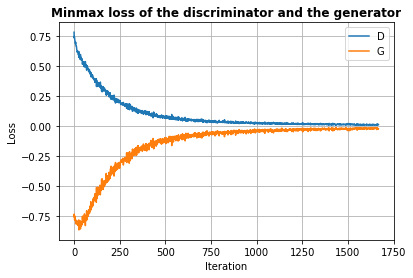

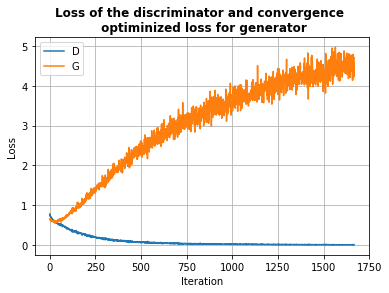

In [121]:
#Plot loss for the discriminator and generator
#1st plot is using the vanilla minimax loss
plt.plot(a.Dloss,label='D')
plt.plot(a.Gloss,label='G')
plt.title('Minmax loss of the discriminator and the generator',fontweight='bold')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

#2nd plot the modified loss for avoiding the vanishing gradient
plt.plot(a.Dloss,label='D')
plt.plot(a.GLogloss,label='G')
plt.title('Loss of the discriminator and convergence \n optiminized loss for generator',fontweight='bold')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

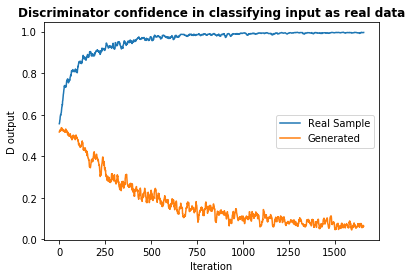

In [122]:
#Evolution of classifier's confidence over time
#smoothed with rolling mean on 10 elements
skip=10
Gen=np.zeros([len(a.outputTrueD)-skip])
Dis=np.zeros([len(a.outputTrueD)-skip])
for i in range(skip,len(a.outputTrueD)):
    for j in range(skip-1,-1,-1):
        Gen[i-skip] += (a.outputFakeD[i-j])/np.float(skip)
        Dis[i-skip] += (a.outputTrueD[i-j])/np.float(skip)

plt.title('Discriminator confidence in classifying input as real data',fontweight='bold')
plt.plot(Dis,label='Real Sample')
plt.plot(Gen,label='Generated')
plt.xlabel('Iteration')
plt.ylabel('D output')
plt.legend()
plt.show()

## Only training the Generator

In [123]:
#Training the generator

#Generate the GAN network
#1st parameter is image size
#2nd parameter is generator layer size
#3rd is discriminator layer size
a2=GAN(784,[500,784],[784,200,200,100])

#Apply gradient descent to the network (only the generator)
#1st parameter is training set
#2nd number of epochs
#3rd parameter is minibatch size
a2.SGD(training_data2[:25000],2,30,etaGenerator=0.001,etaDiscriminator=0)

Epoch 0
Epoch 1


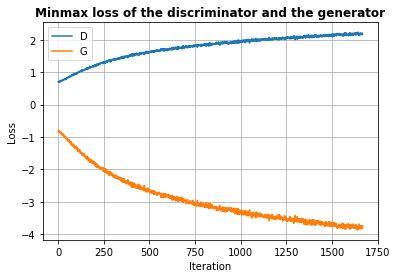

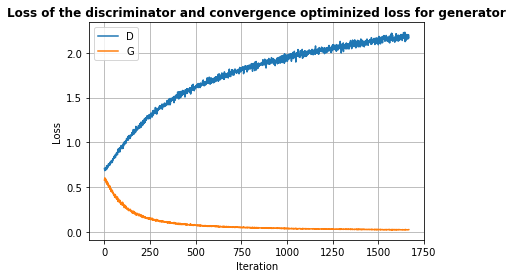

In [124]:
#Plot loss for the discriminator and generator
#1st plot is using the vanilla minimax loss
plt.plot(a2.Dloss,label='D')
plt.plot(a2.Gloss,label='G')
plt.title('Minmax loss of the discriminator and the generator',fontweight='bold')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

#2nd plot the modified loss for avoiding the vanishing gradient
plt.plot(a2.Dloss,label='D')
plt.plot(a2.GLogloss,label='G')
plt.title('Loss of the discriminator and convergence optiminized loss for generator',fontweight='bold')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

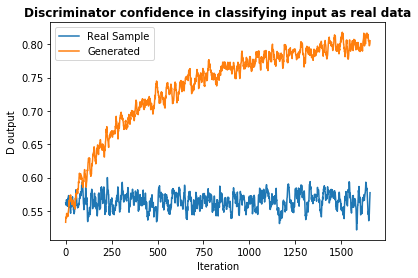

In [125]:
#Evolution of classifier's confidence over time
#smoothed with rolling mean on 10 elements

skip=10
Gen=np.zeros([len(a2.outputTrueD)-skip])
Dis=np.zeros([len(a2.outputTrueD)-skip])
for i in range(skip,len(a.outputTrueD)):
    for j in range(skip-1,-1,-1):
        Gen[i-skip] += (a2.outputFakeD[i-j])/np.float(skip)
        Dis[i-skip] += (a2.outputTrueD[i-j])/np.float(skip)

plt.title('Discriminator confidence in classifying input as real data',fontweight='bold')
plt.plot(Dis,label='Real Sample')
plt.plot(Gen,label='Generated')
plt.xlabel('Iteration')
plt.ylabel('D output')
plt.legend()
plt.show()

## Training both networks

In [126]:
#Training the entire network

#Generate the GAN network
#1st parameter is image size
#2nd parameter is generator layer size
#3rd is discriminator layer size
a3=GAN(784,[500,784],[784,200,200,100])

#Apply gradient descent to the network
#1st parameter is training set
#2nd number of epochs
#3rd parameter is minibatch size
a3.SGD(training_data2[:25000],2,30,etaGenerator=0.001,etaDiscriminator=0.001)

Epoch 0
Epoch 1


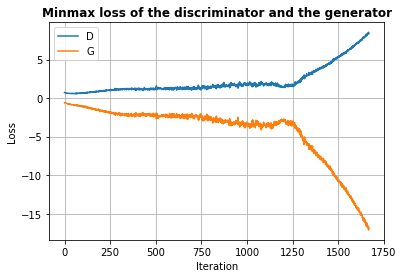

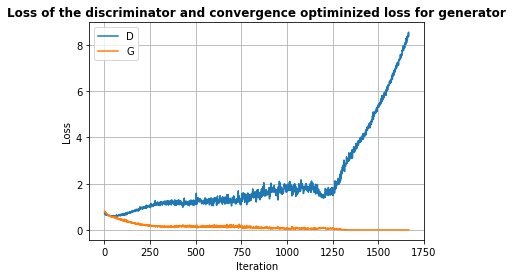

In [127]:
#Plot loss for the discriminator and generator
#1st plot is using the vanilla minimax loss
plt.plot(a3.Dloss,label='D')
plt.plot(a3.Gloss,label='G')
plt.title('Minmax loss of the discriminator and the generator',fontweight='bold')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

#2nd plot the modified loss for avoiding the vanishing gradient
plt.plot(a3.Dloss,label='D')
plt.plot(a3.GLogloss,label='G')
plt.title('Loss of the discriminator and convergence optiminized loss for generator',fontweight='bold')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

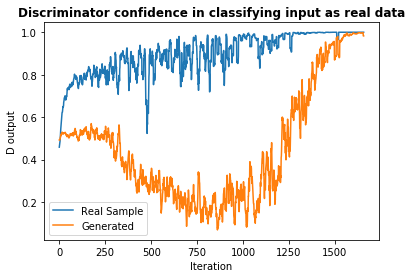

In [128]:
#Evolution of classifier's confidence over time
#smoothed with rolling mean on 10 elements

skip=10
Gen=np.zeros([len(a3.outputTrueD)-skip])
Dis=np.zeros([len(a3.outputTrueD)-skip])
for i in range(skip,len(a.outputTrueD)):
    for j in range(skip-1,-1,-1):
        Gen[i-skip] += (a3.outputFakeD[i-j])/np.float(skip)
        Dis[i-skip] += (a3.outputTrueD[i-j])/np.float(skip)

plt.title('Discriminator confidence in classifying input as real data',fontweight='bold')
plt.plot(Dis,label='Real Sample')
plt.plot(Gen,label='Generated')
plt.xlabel('Iteration')
plt.ylabel('D output')
plt.legend()
plt.show()

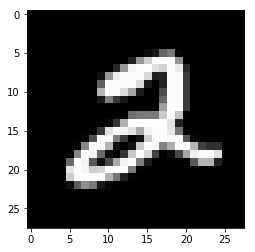

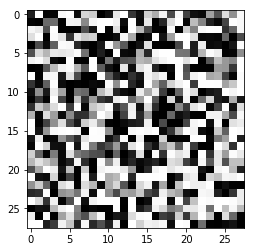

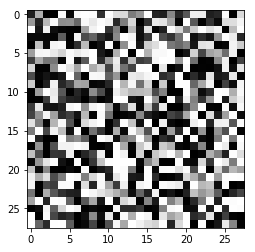

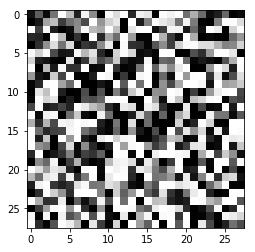

In [129]:
plt.imshow(np.reshape(training_data2[5],[28,28]),cmap='gray')
plt.show()
plt.imshow(np.reshape(a.Generator.FeedForward((np.random.randn(500,1)-0.5)*2),[28,28]),cmap='gray')
plt.show()
plt.imshow(np.reshape(a.Generator.FeedForward(np.random.randn(500,1)*2-1),[28,28]),cmap='gray')
plt.show()
plt.imshow(np.reshape(a.Generator.FeedForward(np.random.randn(500,1)*2-1),[28,28]),cmap='gray')
plt.show()